# 다중 선형 회귀

In [14]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential      # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense           # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import RMSprop,SGD # 옵티마이저
from tensorflow.keras.losses import mse             # 활성화 함수
import pandas as pd 
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import helper
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터 준비

In [2]:
origin = pd.read_excel('https://data.hossam.kr/E04/boston.xlsx')
origin.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,1


## #03. 데이터 전처리

In [3]:
origin.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806,0.166008
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104,0.372456
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,0.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000,0.000000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000,0.000000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000,0.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.000000


In [4]:
origin.isnull().sum()

CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
MEDV         0
CAT. MEDV    0
dtype: int64

### 상자그림


<Axes: >

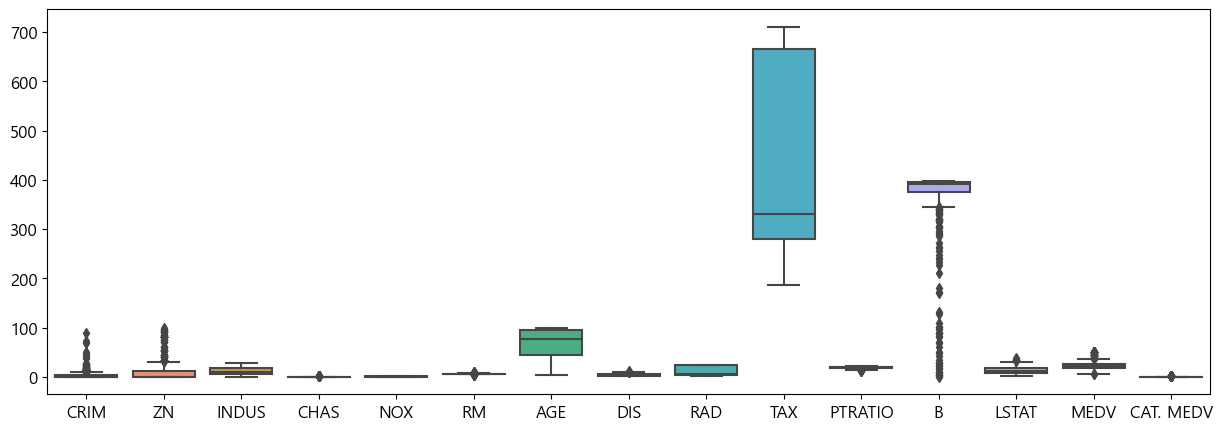

In [5]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15,5))
sns.boxplot(data=origin)

> 표준화 필요

> CAT.MEDV, CHAS 범주형

In [6]:
origin.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806,0.166008
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104,0.372456
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,0.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000,0.000000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000,0.000000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000,0.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.000000


In [7]:
corr_col = origin.corr().iloc[:,-2].abs().sort_values(ascending=False)[1:]
corr_col

CAT. MEDV    0.789789
LSTAT        0.737663
RM           0.695360
PTRATIO      0.507787
INDUS        0.483725
TAX          0.468536
NOX          0.427321
CRIM         0.388305
RAD          0.381626
AGE          0.376955
ZN           0.360445
B            0.333461
DIS          0.249929
CHAS         0.175260
Name: MEDV, dtype: float64

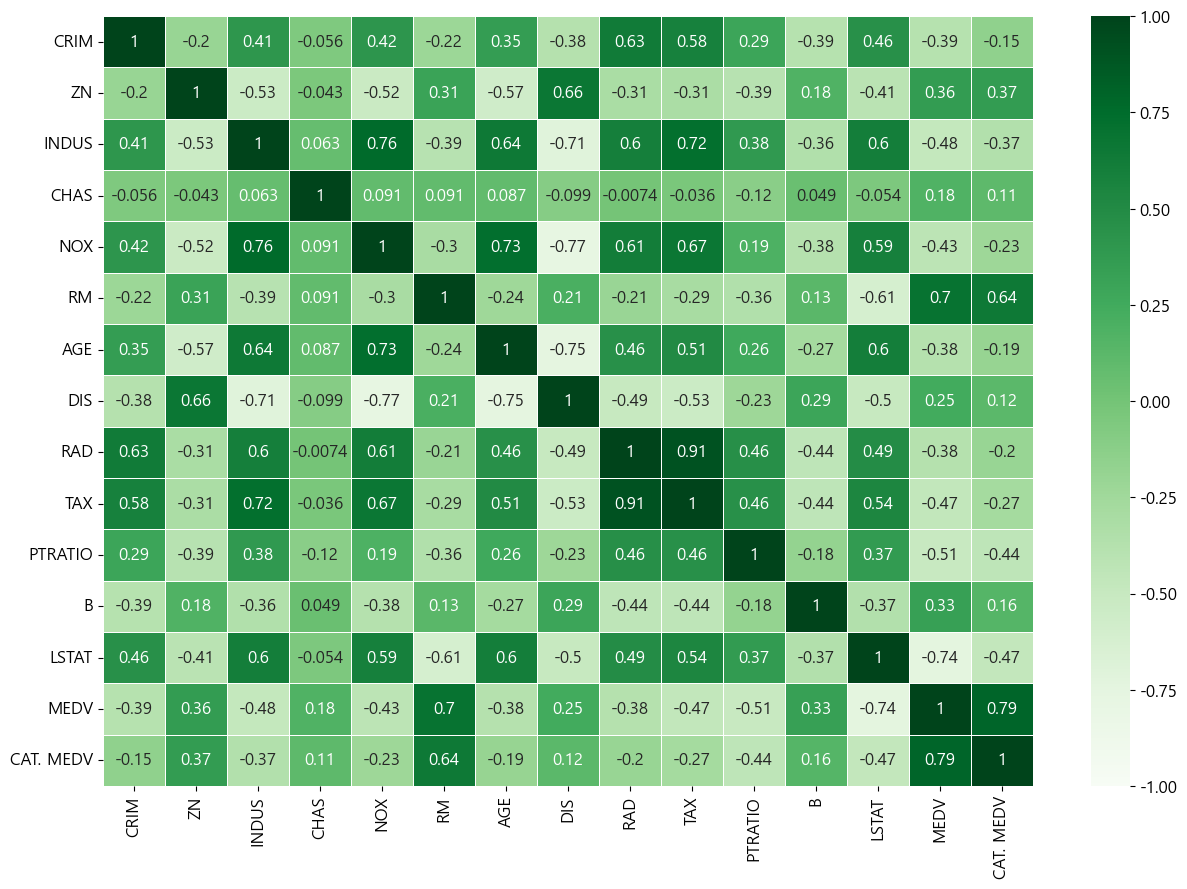

<function matplotlib.pyplot.close(fig=None)>

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(origin.corr(),annot=True,cmap='Greens',vmin=-1,vmax=1,linewidths=0.5)
plt.show()
plt.close

In [9]:
### 

In [10]:
## 범주형 변수 처리 

df= origin.copy()
df.loc[:,['CHAS','CAT. MEDV']] = df.loc[:,['CHAS','CAT. MEDV']].astype('category')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CRIM       506 non-null    float64 
 1   ZN         506 non-null    float64 
 2   INDUS      506 non-null    float64 
 3   CHAS       506 non-null    category
 4   NOX        506 non-null    float64 
 5   RM         506 non-null    float64 
 6   AGE        506 non-null    float64 
 7   DIS        506 non-null    float64 
 8   RAD        506 non-null    int64   
 9   TAX        506 non-null    int64   
 10  PTRATIO    506 non-null    float64 
 11  B          506 non-null    float64 
 12  LSTAT      506 non-null    float64 
 13  MEDV       506 non-null    float64 
 14  CAT. MEDV  506 non-null    category
dtypes: category(2), float64(11), int64(2)
memory usage: 52.7 KB


### 데이터 표준화

In [12]:

num_col = ['CRIM', 'ZN', 'INDUS',  'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

In [13]:
scaler = StandardScaler()
df.loc[:,num_col] = scaler.fit_transform(df.loc[:,num_col])
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,-0.419782,0.284830,-1.287909,0,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0,0
1,-0.417339,-0.487722,-0.593381,0,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6,0
2,-0.417342,-0.487722,-0.593381,0,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7,1
3,-0.416750,-0.487722,-1.306878,0,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4,1
4,-0.412482,-0.487722,-1.306878,0,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2,1


In [19]:
poly = PolynomialFeatures()
poly_test = poly.fit_transform(df.loc[:,num_col])
poly_test = pd.DataFrame(poly_test,columns=poly.get_feature_names_out())
poly_test.head()

,1,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,...,TAX^2,TAX PTRATIO,TAX B,TAX LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2
0,1.0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,...,0.444367,0.972582,-0.294009,0.716979,2.128682,-0.643495,1.569246,0.194527,-0.474379,1.156834
1,1.0,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,...,0.974820,0.299254,-0.435464,0.486200,0.091866,-0.133680,0.149255,0.194527,-0.217191,0.242497
2,1.0,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,...,0.974820,0.299254,-0.391404,1.193412,0.091866,-0.120155,0.366358,0.157154,-0.479172,1.461022
3,1.0,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,...,1.223491,-0.125027,-0.460324,1.505994,0.012776,0.047040,-0.153895,0.173192,-0.566613,1.853728
4,1.0,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,...,1.223491,-0.125027,-0.487854,1.135429,0.012776,0.049853,-0.116028,0.194527,-0.452740,1.053705


In [20]:
poly_test= poly_test.iloc[:,1:]
poly_test.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,TAX^2,TAX PTRATIO,TAX B,TAX LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2
0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,...,0.444367,0.972582,-0.294009,0.716979,2.128682,-0.643495,1.569246,0.194527,-0.474379,1.156834
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,...,0.974820,0.299254,-0.435464,0.486200,0.091866,-0.133680,0.149255,0.194527,-0.217191,0.242497
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,...,0.974820,0.299254,-0.391404,1.193412,0.091866,-0.120155,0.366358,0.157154,-0.479172,1.461022
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,...,1.223491,-0.125027,-0.460324,1.505994,0.012776,0.047040,-0.153895,0.173192,-0.566613,1.853728
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,...,1.223491,-0.125027,-0.487854,1.135429,0.012776,0.049853,-0.116028,0.194527,-0.452740,1.053705


In [23]:
cat_df = df[['CHAS','CAT. MEDV']]
new_df = pd.merge(poly_test,cat_df,left_index=True,right_index=True)
new_df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,TAX B,TAX LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS,CAT. MEDV
0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,...,-0.294009,0.716979,2.128682,-0.643495,1.569246,0.194527,-0.474379,1.156834,0,0
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,...,-0.435464,0.486200,0.091866,-0.133680,0.149255,0.194527,-0.217191,0.242497,0,0
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,...,-0.391404,1.193412,0.091866,-0.120155,0.366358,0.157154,-0.479172,1.461022,0,1
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,...,-0.460324,1.505994,0.012776,0.047040,-0.153895,0.173192,-0.566613,1.853728,0,1
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,...,-0.487854,1.135429,0.012776,0.049853,-0.116028,0.194527,-0.452740,1.053705,0,1


In [24]:
new_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'CRIM^2', 'CRIM ZN', 'CRIM INDUS', 'CRIM NOX',
       'CRIM RM', 'CRIM AGE', 'CRIM DIS', 'CRIM RAD', 'CRIM TAX',
       'CRIM PTRATIO', 'CRIM B', 'CRIM LSTAT', 'ZN^2', 'ZN INDUS', 'ZN NOX',
       'ZN RM', 'ZN AGE', 'ZN DIS', 'ZN RAD', 'ZN TAX', 'ZN PTRATIO', 'ZN B',
       'ZN LSTAT', 'INDUS^2', 'INDUS NOX', 'INDUS RM', 'INDUS AGE',
       'INDUS DIS', 'INDUS RAD', 'INDUS TAX', 'INDUS PTRATIO', 'INDUS B',
       'INDUS LSTAT', 'NOX^2', 'NOX RM', 'NOX AGE', 'NOX DIS', 'NOX RAD',
       'NOX TAX', 'NOX PTRATIO', 'NOX B', 'NOX LSTAT', 'RM^2', 'RM AGE',
       'RM DIS', 'RM RAD', 'RM TAX', 'RM PTRATIO', 'RM B', 'RM LSTAT', 'AGE^2',
       'AGE DIS', 'AGE RAD', 'AGE TAX', 'AGE PTRATIO', 'AGE B', 'AGE LSTAT',
       'DIS^2', 'DIS RAD', 'DIS TAX', 'DIS PTRATIO', 'DIS B', 'DIS LSTAT',
       'RAD^2', 'RAD TAX', 'RAD PTRATIO', 'RAD B', 'RAD LSTAT', 'TAX^2',
       'TAX PTRATIO', 'TAX B', 'TAX

### 독립변수 종속변수 분리

In [25]:
y= df[['MEDV']]
y.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [26]:
x=new_df.copy()


### 더미변수 

In [27]:

x = pd.get_dummies(x,drop_first=True,dtype='int')
x.head()


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,TAX B,TAX LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS_1,CAT. MEDV_1
0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,...,-0.294009,0.716979,2.128682,-0.643495,1.569246,0.194527,-0.474379,1.156834,0,0
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,...,-0.435464,0.486200,0.091866,-0.133680,0.149255,0.194527,-0.217191,0.242497,0,0
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,...,-0.391404,1.193412,0.091866,-0.120155,0.366358,0.157154,-0.479172,1.461022,0,1
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,...,-0.460324,1.505994,0.012776,0.047040,-0.153895,0.173192,-0.566613,1.853728,0,1
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,...,-0.487854,1.135429,0.012776,0.049853,-0.116028,0.194527,-0.452740,1.053705,0,1


In [28]:

print(x.shape,y.shape)

(506, 92) (506, 1)


## #05. 데이터 분할

### 랜덤시드 고정

In [29]:
np.random.seed(777)

In [30]:
x.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,TAX B,TAX LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS_1,CAT. MEDV_1
0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,...,-0.294009,0.716979,2.128682,-0.643495,1.569246,0.194527,-0.474379,1.156834,0,0
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,...,-0.435464,0.486200,0.091866,-0.133680,0.149255,0.194527,-0.217191,0.242497,0,0
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,...,-0.391404,1.193412,0.091866,-0.120155,0.366358,0.157154,-0.479172,1.461022,0,1
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,...,-0.460324,1.505994,0.012776,0.047040,-0.153895,0.173192,-0.566613,1.853728,0,1
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,...,-0.487854,1.135429,0.012776,0.049853,-0.116028,0.194527,-0.452740,1.053705,0,1


In [31]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=777)
print(len(y_train),len(x_test))


354 152


In [32]:
x_test.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,TAX B,TAX LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS_1,CAT. MEDV_1
207,-0.391193,-0.487722,-0.079780,-0.567496,-0.714658,0.146691,0.266139,-0.637962,-0.779455,0.066796,...,-0.279940,-0.590757,0.004462,0.023990,0.050625,0.128987,0.272202,0.574429,0,0
425,1.425197,-0.487722,1.015999,1.073787,-0.553671,0.953916,-0.896281,1.661245,1.530926,0.806576,...,-5.858083,2.518697,0.650565,-3.086359,1.326987,14.642069,-6.295392,2.706719,0,0
408,0.441097,-0.487722,1.015999,0.365444,-0.951151,1.042817,-1.112527,1.661245,1.530926,0.806576,...,-0.705568,2.950034,0.650565,-0.371732,1.554239,0.212407,-0.888090,3.713175,0,0
63,-0.405796,0.585267,-0.876445,-0.878475,0.680083,-0.895234,1.989827,-0.178120,-0.737880,0.575395,...,-0.314764,0.326126,0.331079,0.245451,-0.254311,0.181970,-0.188538,0.195343,0,0
290,-0.416442,2.945843,-0.902709,-1.241285,0.821124,-1.446423,0.628275,-0.637962,-0.969512,0.344213,...,-0.427605,1.267005,0.118483,0.151816,-0.449835,0.194527,-0.576388,1.707854,0,0


<Axes: >

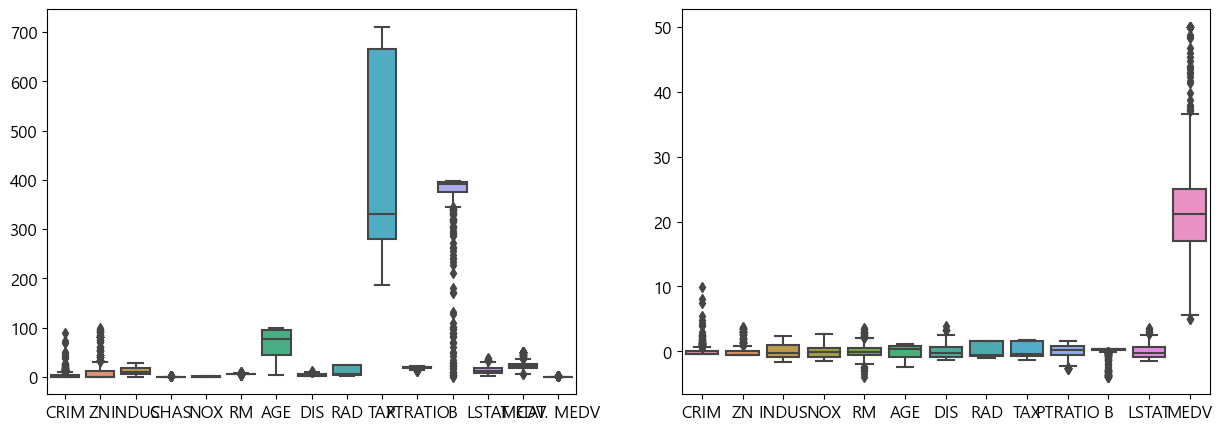

In [33]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=origin,ax=ax[0])
sns.boxplot(data=df,ax=ax[1])

## #06.모델개발
### 1.모델 정의

In [34]:
x_train.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,TAX B,TAX LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS_1,CAT. MEDV_1
372,0.541569,-0.487722,1.015999,0.978765,-0.583589,0.747665,-1.267069,1.661245,1.530926,0.806576,...,-0.147613,-0.809683,0.650565,-0.077771,-0.426585,0.009297,0.050996,0.279719,1,1
18,-0.327103,-0.487722,-0.437258,-0.144217,-1.180521,-1.137046,0.000693,-0.637962,-0.601276,1.176466,...,0.446214,0.081170,1.384072,-0.873069,-0.158818,0.550730,0.100182,0.018224,0,0
185,-0.413480,-0.487722,-1.266023,-0.576134,-0.187534,0.008005,-0.244978,-0.752922,-1.278354,-0.303094,...,-0.426601,-0.089047,0.091866,-0.101146,-0.021113,0.111363,0.023245,0.004852,0,0
57,-0.418851,3.804234,-1.432360,-1.241285,0.757015,-0.998360,2.153307,-0.523001,-0.904180,-1.551473,...,-0.359135,1.103046,2.407068,-0.616236,1.892706,0.157763,-0.484554,1.488257,0,1
261,-0.358360,0.370669,-1.045700,0.797361,1.759974,0.740552,-0.786851,-0.523001,-0.856665,-2.522434,...,-0.297713,0.647610,6.362674,-0.876611,1.906875,0.120774,-0.262718,0.571485,0,1


In [36]:
len(x_train.columns)

92

In [37]:
model = Sequential()
model.add(Dense(184,activation = 'relu',input_shape=(len(x_train.columns),)))
model.add(Dense(92,activation = 'relu'))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mse',metrics = ['mae'])
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x000002C79B380280>>

### 2. 학습하기

In [38]:
result= model.fit(x_train,y_train, epochs=500,validation_data = (x_test,y_test),callbacks=[
    EarlyStopping(monitor='val_loss',patience=10,verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.5,min_lir=0.0001,verbose=1),
    ])



result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs',inplace=True)
result_df

Epoch 1/500
12/12 [==============================] - 2s 51ms/step - loss: 477.9651 - mae: 19.7612 - val_loss: 336.1332 - val_mae: 15.8986 - lr: 0.0010
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 299.9785 - mae: 14.7557 - val_loss: 233.6214 - val_mae: 13.1407 - lr: 0.0010
Epoch 3/500
12/12 [==============================] - 0s 15ms/step - loss: 204.5766 - mae: 12.2423 - val_loss: 154.2476 - val_mae: 10.4571 - lr: 0.0010
Epoch 4/500
12/12 [==============================] - 0s 13ms/step - loss: 128.4535 - mae: 9.6127 - val_loss: 95.1510 - val_mae: 7.7834 - lr: 0.0010
Epoch 5/500
12/12 [==============================] - 0s 9ms/step - loss: 69.6334 - mae: 6.6317 - val_loss: 67.0493 - val_mae: 6.0759 - lr: 0.0010
Epoch 6/500
12/12 [==============================] - 0s 12ms/step - loss: 46.4968 - mae: 5.1661 - val_loss: 52.8172 - val_mae: 5.2629 - lr: 0.0010
Epoch 7/500
12/12 [==============================] - 0s 9ms/step - loss: 35.9900 - mae: 4.4292 - val_loss:

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,477.965118,19.761204,336.133209,15.898560,0.001000
2,299.978455,14.755714,233.621399,13.140683,0.001000
3,204.576599,12.242268,154.247635,10.457080,0.001000
4,128.453506,9.612694,95.151024,7.783404,0.001000
5,69.633423,6.631703,67.049294,6.075876,0.001000
6,46.496799,5.166144,52.817158,5.262898,0.001000
7,35.989998,4.429228,42.046654,4.777286,0.001000
8,31.299623,4.202049,37.084179,4.602315,0.001000
9,26.865780,3.825572,33.554089,4.409729,0.001000


### 7) 학습 결과 평가
#### 1. 학습결과 시각화

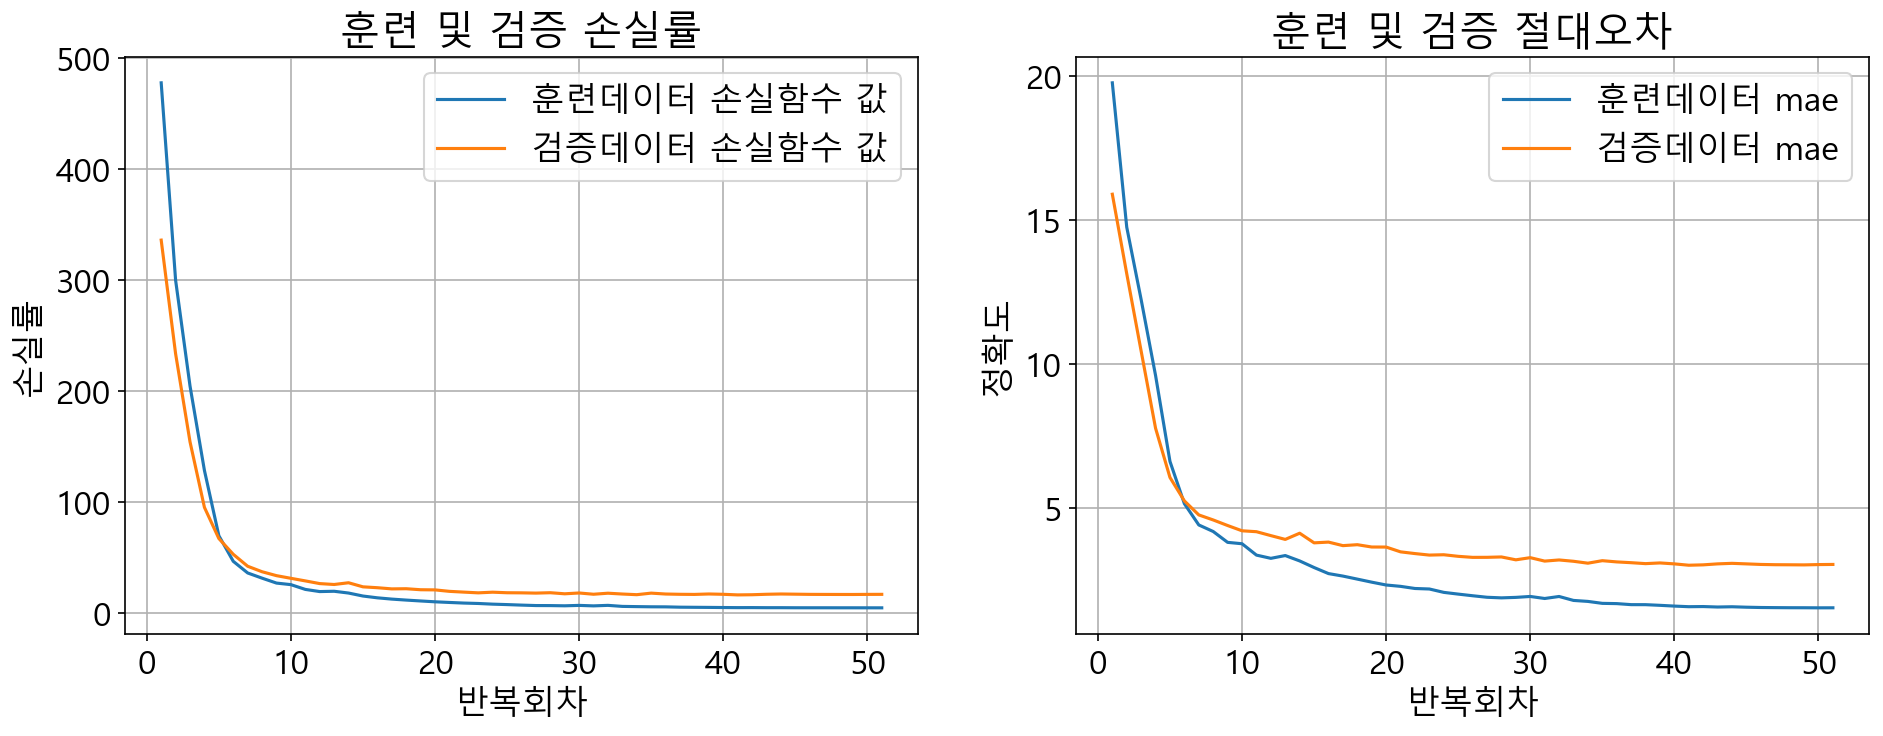

In [39]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sns.lineplot(x=result_df.index , y='loss',data = result_df,label = '훈련데이터 손실함수 값',ax=ax1)
sns.lineplot(x=result_df.index , y= 'val_loss',data=result_df,label = '검증데이터 손실함수 값',ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()
# 2) 훈련 및 검증 절대오차 그리기
sns.lineplot(x=result_df.index,y='mae',data=result_df,label='훈련데이터 mae',ax=ax2)
sns.lineplot(x=result_df.index,y='val_mae',data=result_df,label='검증데이터 mae',ax=ax2)

ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

#### 2. 모델 성능 평가

In [40]:
evaluate1 = model.evaluate(x_train,y_train)

evaluate2 = model.evaluate(x_test,y_test)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate2[0], evaluate2[1]))



5/5 [==============================] - 0s 3ms/step - loss: 16.7043 - mae: 3.0600
최종 훈련 손실률: 4.533280, 최종 훈련 절대오차: 1.554812
최종 훈련 손실률: 16.704313, 최종 훈련 절대오차: 3.059951


## #08. 학습 결과 적용
### 1. 테스트 데이터에 대한 예측 결과 산정

In [41]:
results = model.predict(x_test)
print(results)

5/5 [==============================] - 0s 2ms/step
[[17.806425 ]
 [12.486586 ]
 [13.2688465]
 [22.335346 ]
 [32.59034  ]
 [19.607876 ]
 [24.187206 ]
 [44.96958  ]
 [12.472004 ]
 [46.637043 ]
 [24.320175 ]
 [22.88015  ]
 [12.153017 ]
 [23.050049 ]
 [17.10323  ]
 [35.517555 ]
 [ 6.8473053]
 [17.730433 ]
 [22.768475 ]
 [16.081097 ]
 [16.882252 ]
 [21.369781 ]
 [ 8.989862 ]
 [24.967611 ]
 [13.0484085]
 [25.554054 ]
 [26.6557   ]
 [27.296919 ]
 [20.752993 ]
 [25.418354 ]
 [26.65569  ]
 [27.346848 ]
 [20.31684  ]
 [22.836472 ]
 [24.548866 ]
 [26.015404 ]
 [ 8.938137 ]
 [25.968868 ]
 [14.9130535]
 [15.85293  ]
 [24.53175  ]
 [16.3701   ]
 [15.215957 ]
 [13.22595  ]
 [14.826605 ]
 [18.998493 ]
 [12.192258 ]
 [18.792599 ]
 [17.625643 ]
 [18.789688 ]
 [29.923935 ]
 [39.9568   ]
 [12.997408 ]
 [18.510475 ]
 [20.255688 ]
 [18.127325 ]
 [18.337288 ]
 [12.851548 ]
 [25.99446  ]
 [14.270302 ]
 [25.844238 ]
 [21.18624  ]
 [24.865913 ]
 [15.588809 ]
 [22.318565 ]
 [31.818851 ]
 [43.463257 ]
 [19.250433

### 2. 결과 데이터 구성

In [42]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

12/12 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 2ms/step


In [43]:
train_df = pd.DataFrame(x_train,columns =x_train.columns)
train_df['무게(관측치)'] = y_train
train_df['무게(예측치)'] = train_pred

train_df['훈련오차'] = train_df['무게(관측치)'] - train_df['무게(예측치)']

train_df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS_1,CAT. MEDV_1,무게(관측치),무게(예측치),훈련오차
372,0.541569,-0.487722,1.015999,0.978765,-0.583589,0.747665,-1.267069,1.661245,1.530926,0.806576,...,-0.077771,-0.426585,0.009297,0.050996,0.279719,1,1,50.0,39.674965,10.325035
18,-0.327103,-0.487722,-0.437258,-0.144217,-1.180521,-1.137046,0.000693,-0.637962,-0.601276,1.176466,...,-0.873069,-0.158818,0.550730,0.100182,0.018224,0,0,20.2,17.080027,3.119973
185,-0.413480,-0.487722,-1.266023,-0.576134,-0.187534,0.008005,-0.244978,-0.752922,-1.278354,-0.303094,...,-0.101146,-0.021113,0.111363,0.023245,0.004852,0,0,29.6,26.701927,2.898073
57,-0.418851,3.804234,-1.432360,-1.241285,0.757015,-0.998360,2.153307,-0.523001,-0.904180,-1.551473,...,-0.616236,1.892706,0.157763,-0.484554,1.488257,0,1,31.6,32.225433,-0.625433
261,-0.358360,0.370669,-1.045700,0.797361,1.759974,0.740552,-0.786851,-0.523001,-0.856665,-2.522434,...,-0.876611,1.906875,0.120774,-0.262718,0.571485,0,1,43.1,38.671890,4.428110


In [44]:
test_df = pd.DataFrame(x_test,columns = x_test.columns)
test_df['무게(관측치)'] = y_test
test_df['무게(예측치)'] = test_pred

test_df['훈련오차'] = test_df['무게(관측치)'] - test_df['무게(예측치)']

test_df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS_1,CAT. MEDV_1,무게(관측치),무게(예측치),훈련오차
207,-0.391193,-0.487722,-0.079780,-0.567496,-0.714658,0.146691,0.266139,-0.637962,-0.779455,0.066796,...,0.023990,0.050625,0.128987,0.272202,0.574429,0,0,22.5,17.806425,4.693575
425,1.425197,-0.487722,1.015999,1.073787,-0.553671,0.953916,-0.896281,1.661245,1.530926,0.806576,...,-3.086359,1.326987,14.642069,-6.295392,2.706719,0,0,8.3,12.486586,-4.186586
408,0.441097,-0.487722,1.015999,0.365444,-0.951151,1.042817,-1.112527,1.661245,1.530926,0.806576,...,-0.371732,1.554239,0.212407,-0.888090,3.713175,0,0,17.2,13.268847,3.931153
63,-0.405796,0.585267,-0.876445,-0.878475,0.680083,-0.895234,1.989827,-0.178120,-0.737880,0.575395,...,0.245451,-0.254311,0.181970,-0.188538,0.195343,0,0,25.0,22.335346,2.664654
290,-0.416442,2.945843,-0.902709,-1.241285,0.821124,-1.446423,0.628275,-0.637962,-0.969512,0.344213,...,0.151816,-0.449835,0.194527,-0.576388,1.707854,0,0,28.5,32.590340,-4.090340


### 3. 실제 결과값과 머신러닝에 의한 예측값 비교

In [32]:
# fig,ax = plt.subplots(3,2,figsize=(15,15))
# ## 관측치 시각화
# sns.scatterplot(x=train_df['길이'],y=train_df['무게(관측치)'],label = 'train data',ax=ax[0][0])
# # ## 관측치 선그래프
# sns.regplot(x=train_df['길이'],y=train_df['무게(예측치)'],ax=ax[0][0],color='red')
# ## 관측치 시각화
# sns.scatterplot(x=train_df['높이'],y=train_df['무게(관측치)'],label = 'train data',ax=ax[1][0])
# # ## 관측치 선그래프
# sns.regplot(x=train_df['높이'],y=train_df['무게(예측치)'],ax=ax[1][0],color='red')
# ## 관측치 시각화
# sns.scatterplot(x=train_df['두께'],y=train_df['무게(관측치)'],label = 'train data',ax=ax[2][0])
# # ## 관측치 선그래프
# sns.regplot(x=train_df['두께'],y=train_df['무게(예측치)'],ax=ax[2][0],color='red')

# ## 관측치 시각화
# sns.scatterplot(x=test_df['길이'],y=test_df['무게(관측치)'],label = 'train data',ax=ax[0][1])
# # ## 관측치 선그래프
# sns.regplot(x=test_df['길이'],y=test_df['무게(예측치)'],ax=ax[0][1],color='red')
# ## 관측치 시각화
# sns.scatterplot(x=test_df['높이'],y=test_df['무게(관측치)'],label = 'train data',ax=ax[1][1])
# # ## 관측치 선그래프
# sns.regplot(x=test_df['높이'],y=test_df['무게(예측치)'],ax=ax[1][1],color='red')
# ## 관측치 시각화
# sns.scatterplot(x=test_df['두께'],y=test_df['무게(관측치)'],label = 'train data',ax=ax[2][1])
# # ## 관측치 선그래프
# sns.regplot(x=test_df['두께'],y=test_df['무게(예측치)'],ax=ax[2][1],color='red')




# # ## 예측치 시각화
# # sns.scatterplot(x=kdf['검증데이터'],y=kdf['예측값'],label = '예측값')
# # # ## 예측치 선그래프
# # sns.regplot(x=kdf['검증데이터'],y=kdf['예측값'])



In [33]:
# for key in ['길이','높이','두께']:
#     helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
#                    test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
#                    figsize=(15, 5))